In [6]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random
from matplotlib import image
from gym import Env, spaces
import time

# https://blog.paperspace.com/creating-custom-environments-openai-gym/

In [ ]:
img = image.imread(r"cadaver_slice_160.png")

In [ ]:
I = img
I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)

img = Image.fromarray(I8)
print(img.getextrema())
img = img.point(lambda p: p > 160)
print(img.getextrema())

plt.imshow(img, cmap ='gray')
plt.colorbar()
plt.show()


In [ ]:
print(img.size)

# Create Environment

In [66]:
class Center_FOV(Env):

    ACTION = ["UP", "DOWN"]

    def __init__(self):
        super(Center_FOV, self).__init__()

        # get image and threshold it. This will be the backgroud. 
        img = image.imread(r"cadaver_slice_160.png")
        I = img#[100:300, 50:350]
        
        I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)

        img = Image.fromarray(I8)
        print(img.getextrema())
        img = img.point(lambda p: p > 160)
        img = img.crop((50, 100, 350, 300))
        

        # Define a 2-D observation space
        self.observation_shape = img.size

        # Going up and down? 
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)
    
        
        # Define an action space ranging from 0 to 4
        self.action_space = spaces.Discrete(2,)
                        
        # Create a canvas to render the environment images upon 
        self.canvas = img
        
        # Define elements present inside the environment
        self.elements = []
        


        # Permissible area of the FOV viewer to be 
        self.y_min = 0#int (self.observation_shape[0])
        print(self.y_min)
        self.x_min = 0#int (self.observation_shape[1])
        print(self.x_min)
        self.y_max = int (self.observation_shape[0])
        print(self.y_max)
        self.x_max = int (self.observation_shape[1])
        print(self.x_max)

    def reset(self):

        # Reset the reward
        self.ep_return  = 0

        # Reset the Canvas 
        img = image.imread(r"cadaver_slice_160.png")
        #I = img
        I = img#[100:300, 50:350]
        I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)

        img = Image.fromarray(I8)
        print(img.getextrema())
        img = img.point(lambda p: p > 160)
        #img = img[100:300, 50:350]
        img = img.crop((50, 100, 350, 300))
        self.canvas = img

        plt.imshow(self.canvas, cmap = 'gray')
        plt.show()



        

        # Intialise the chopper
        #self.grabber = FOV_grabber("FOV_Grabber", self.x_max, self.x_min, self.y_max, self.y_min)
        self.grabber = FOV_Viewer("FOV_Grabber", self.x_max, self.x_min, self.y_max, self.y_min)
        # Determine a place to intialise the chopper in
        x = random.randrange(0, int(self.observation_shape[0] - self.grabber.FOV_w))
        y = random.randrange(0, int(self.observation_shape[1] - self.grabber.FOV_h))
        print(x)
        print(y)
        self.grabber.set_position(x,y)
        print(self.grabber.get_position())


        # return the observation
        return self.canvas.crop((self.grabber.x, self.grabber.y, self.grabber.x+self.grabber.FOV_w, self.grabber.y+self.grabber.FOV_h))

        
        #return self.canvas[self.grabber.x:self.grabber.x+self.grabber.FOV_w, self.grabber.y:self.grabber.y+self.grabber.FOV_h]

# This is a class FOV Viewer, this will be determining the FOV and then calculating the total pixel values. 

In [67]:
class FOV_Viewer(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name
        self.FOV_w = 50
        self.FOV_h = 50
    
    def set_position(self, x, y):
        self.x = x #self.clamp(self.x, self.x_min, self.x_max - self.FOV_w)
        print(x)
        print('yolo')
        print(y)
        self.y = y #self.clamp(self.y, self.y_min, self.y_max - self.FOV_h)
        
        # count = (self.canvas[x:self.FOV_w, y:y+self.FOV_h] == 1).sum()
        # x_center, y_center = np.argwhere(self.canvas==1).sum(0)/count
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.FOV_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.FOV_h)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

# This is the field of view of the image. 

In [64]:
# class FOV_grabber(FOV_Viewer):
#     def __init__(self, name, x_max, x_min, y_max, y_min):
#         super(FOV_grabber, self).__init__(name, x_max, x_min, y_max, y_min)

#         self.FOV_w = 50
#         self.FOV_h = 50
#         #self.current_FOV = self.canvas[self.x:self.x+self.FOV_w, self.y:self.y+self.FOV_h]

<!-- def draw_elements_on_canvas(self):
    # Init the canvas 
     # get image and threshold it. This will be the backgroud. 
        img = image.imread(r"cadaver_slice_160.png")
        I = img
        I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)

        img = Image.fromarray(I8)
        print(img.getextrema())
        img = img.point(lambda p: p > 160) -->
        

In [ ]:
# # Not necessary???

# def draw_elements_on_canvas(self):
#     # Init the canvas 
#     img = image.imread(r"cadaver_slice_160.png")
#     I = img
#     I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)

#     img = Image.fromarray(I8)
#     print(img.getextrema())
#     img = img.point(lambda p: p > 160)


#     # draw the bounding box on the canvas. 


# check to make sure the environment works. 

(0, 255)
0
0
300
200
(0, 255)


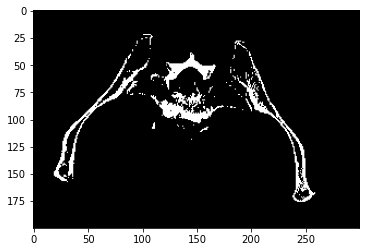

172
102
172
yolo
102
(172, 102)


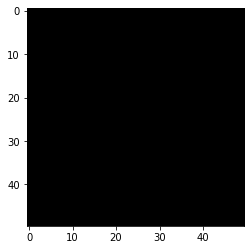

In [74]:
env = Center_FOV()
obs = env.reset()
plt.imshow(obs, cmap = 'gray')
#plt.colorbar()
plt.show()